# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
#The new version of dataset is only available in the tfds-nightly package. 
%pip --no-cache-dir install tfds-nightly --user 
!pip install tensorflow --upgrade --user

Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: tensorflow in /root/.local/lib/python3.7/site-packages (2.6.0)


In [ ]:
# obsolete: original
# The new version of dataset is only available in the tfds-nightly package.
#%pip --no-cache-dir install tensorflow-datasets --user
# DON'T MISS TO RESTART THE KERNEL

In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [2]:
# TODO: Make all other necessary imports.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [114]:
from workspace_utils import active_session

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

# TODO: Create a training set, a validation set and a test set.
train_set = dataset['train']
test_set = dataset['test']
val_set = dataset['validation']


2021-10-23 23:47:59.190676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-23 23:47:59.190872: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/root/.local/lib/python3.7/site-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 25, in <module>
    from tensorflow_datasets.scripts.cli import main as main_cli
  File "/root/.local/lib/python3.7/site-packages/tensorflow_datasets/scripts/cli/main.py", line 40, in <module>
    from tensorflow_datasets.scripts.utils import flag_utils
ModuleNotFoundErro

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [5]:
dataset_info.features['image']

Image(shape=(None, None, 3), dtype=tf.uint8)

In [6]:
num_classes = dataset_info.features['label'].num_classes
print(num_classes)

102


In [7]:
dataset_info.splits['train']

<SplitInfo num_examples=1020, num_shards=1>

In [8]:
dataset_info.splits['validation']

<SplitInfo num_examples=1020, num_shards=1>

In [9]:
dataset_info.splits['test']

<SplitInfo num_examples=6149, num_shards=2>

## Explore the Dataset

In [10]:
# TODO: Get the number of examples in each set from the dataset info.
num_training_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes

print('Number of train samples:', num_training_examples)
print('Number of validation samples:', num_validation_examples)
print('Number of test samples:', num_test_examples)
print('Number of label classes:', num_classes)

Number of train samples: 1020
Number of validation samples: 1020
Number of test samples: 6149
Number of label classes: 102


In [11]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for oneimage, label in train_set.take(3):
    print('Shape of image: {0} , label value of image: {1}'.format(oneimage.shape, label.numpy()))

Shape of image: (500, 667, 3) , label value of image: 72
Shape of image: (500, 666, 3) , label value of image: 84
Shape of image: (670, 500, 3) , label value of image: 70


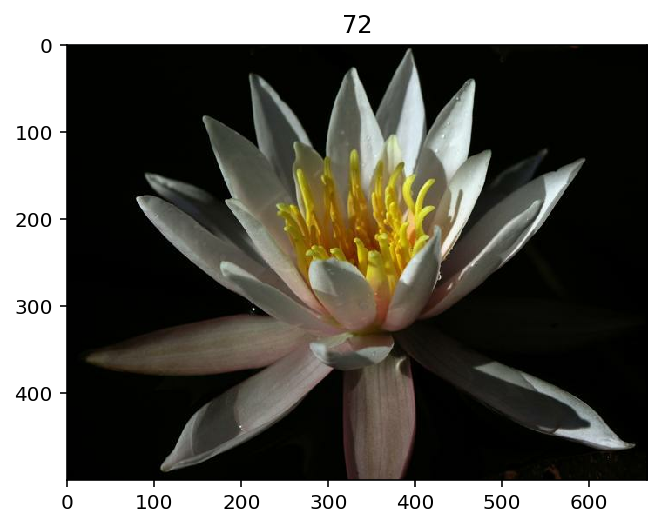

In [12]:
# TODO: Plot 1 image from the training set. 
# Set the title of the plot to the corresponding image label. 
for image, label in train_set.take(1):
    image = image.numpy()
    label = label.numpy()
    plt.title(label)
    plt.imshow(image)
    plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [13]:
import json
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

print('class_names Datatpye: ', type(class_names))

for key in sorted(class_names.keys()):
    print(key, ' : ', class_names[key])

class_names Datatpye:  <class 'dict'>
1  :  pink primrose
10  :  globe thistle
100  :  blanket flower
101  :  trumpet creeper
102  :  blackberry lily
11  :  snapdragon
12  :  colt's foot
13  :  king protea
14  :  spear thistle
15  :  yellow iris
16  :  globe-flower
17  :  purple coneflower
18  :  peruvian lily
19  :  balloon flower
2  :  hard-leaved pocket orchid
20  :  giant white arum lily
21  :  fire lily
22  :  pincushion flower
23  :  fritillary
24  :  red ginger
25  :  grape hyacinth
26  :  corn poppy
27  :  prince of wales feathers
28  :  stemless gentian
29  :  artichoke
3  :  canterbury bells
30  :  sweet william
31  :  carnation
32  :  garden phlox
33  :  love in the mist
34  :  mexican aster
35  :  alpine sea holly
36  :  ruby-lipped cattleya
37  :  cape flower
38  :  great masterwort
39  :  siam tulip
4  :  sweet pea
40  :  lenten rose
41  :  barbeton daisy
42  :  daffodil
43  :  sword lily
44  :  poinsettia
45  :  bolero deep blue
46  :  wallflower
47  :  marigold
48  :  b

In [14]:
for image, label in train_set.take(1):
    ymin = label.numpy()

print(ymin)

ymax=ymin
i=0
for image, label in train_set:
    i+=1
    ymin = min(label.numpy(), ymin)
    ymax = max(label.numpy(), ymax)

for image, label in val_set:
    i+=1
    ymin = min(label.numpy(), ymin)
    ymax = max(label.numpy(), ymax)    
    
for image, label in test_set:
    i+=1
    ymin = min(label.numpy(), ymin)
    ymax = max(label.numpy(), ymax)
    
print('ymin: ', ymin)
print('ymin: ', ymax)
print('Diff Iterations and total Samples:', i - (num_training_examples + num_validation_examples +num_test_examples))

72
ymin:  0
ymin:  101
Diff Iterations and total Samples: 0


Label Index shift necessary as dictionary has one-based index!

In [15]:
class_names_new = dict()
for key in sorted(class_names.keys()):
    oldindexint = int(key)
    class_names_new[str(oldindexint-1)] = class_names[key]

In [16]:
for key in sorted(class_names_new.keys()):
    print(key, ' : ', class_names_new[key])

0  :  pink primrose
1  :  hard-leaved pocket orchid
10  :  snapdragon
100  :  trumpet creeper
101  :  blackberry lily
11  :  colt's foot
12  :  king protea
13  :  spear thistle
14  :  yellow iris
15  :  globe-flower
16  :  purple coneflower
17  :  peruvian lily
18  :  balloon flower
19  :  giant white arum lily
2  :  canterbury bells
20  :  fire lily
21  :  pincushion flower
22  :  fritillary
23  :  red ginger
24  :  grape hyacinth
25  :  corn poppy
26  :  prince of wales feathers
27  :  stemless gentian
28  :  artichoke
29  :  sweet william
3  :  sweet pea
30  :  carnation
31  :  garden phlox
32  :  love in the mist
33  :  mexican aster
34  :  alpine sea holly
35  :  ruby-lipped cattleya
36  :  cape flower
37  :  great masterwort
38  :  siam tulip
39  :  lenten rose
4  :  english marigold
40  :  barbeton daisy
41  :  daffodil
42  :  sword lily
43  :  poinsettia
44  :  bolero deep blue
45  :  wallflower
46  :  marigold
47  :  buttercup
48  :  oxeye daisy
49  :  common dandelion
5  :  t

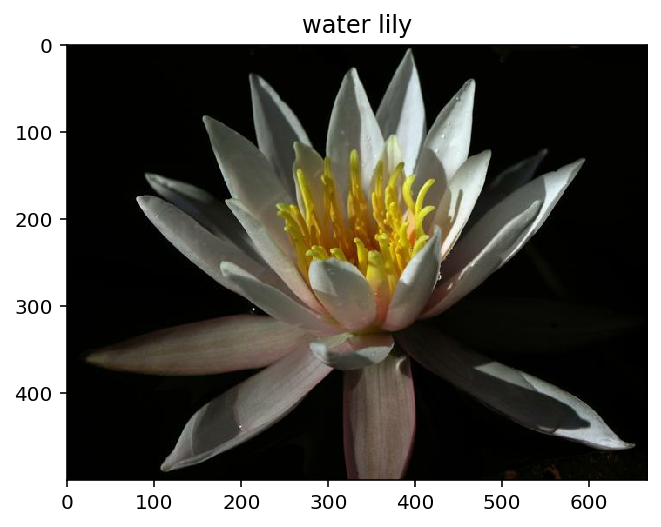

In [17]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in train_set.take(1):
    image = image.numpy()
    plt.title(class_names_new[str(label.numpy())])
    plt.imshow(image)
    plt.show()


In [18]:
class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

## Create Pipeline

In [19]:
# TODO: Create a pipeline for each set.

# - As MobileNet shall be used as convolutional neural networt, image shape has to be adapted to it's size: (224,224,3)
# - normalize the images using format_image()
# - shuffle rate of 25%
# - only shuffle traning set - validation set and test set has no feedback to the nn

batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

# from above:
#num_training_examples = dataset_info.splits['train'].num_examples

train_batches = train_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
val_batches = val_set.map(format_image).batch(batch_size).prefetch(1)
test_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

Verifiy train_batches picture

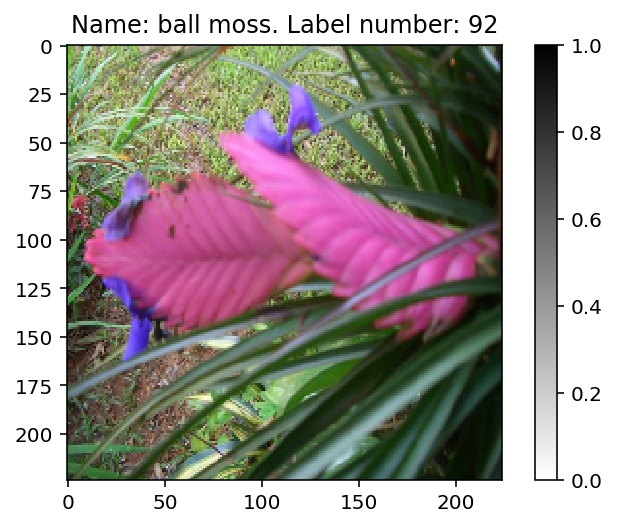

In [20]:
for image_batch, label_batch in train_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

# Plot the image
plt.imshow(images[0], cmap = plt.cm.binary)
plt.colorbar()

plt.title('Name: '+class_names_new[str(labels[0])]+ '. Label number: '+str(labels[0]))
plt.show()

In [21]:
Verifiy val_batches picture

SyntaxError: invalid syntax (<ipython-input-21-e72d9b2795e1>, line 1)

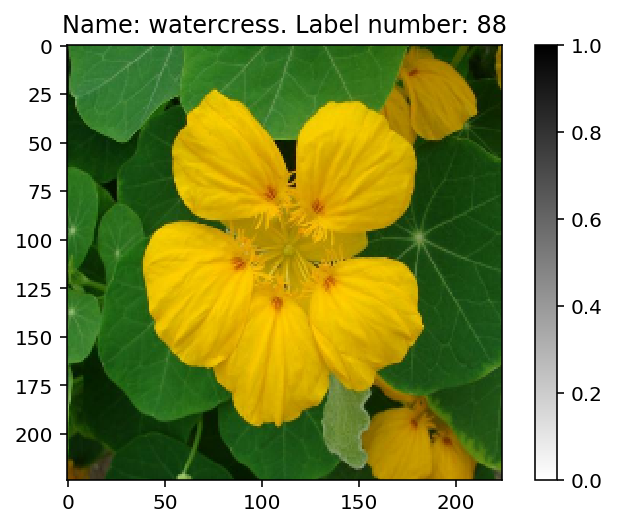

In [22]:
for image_batch, label_batch in val_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

# Plot the image
plt.imshow(images[0], cmap = plt.cm.binary)
plt.colorbar()

plt.title('Name: '+class_names_new[str(labels[0])]+ '. Label number: '+str(labels[0]))
plt.show()

In [23]:
Verifiy test_batches picture

SyntaxError: invalid syntax (<ipython-input-23-355b6f91b21a>, line 1)

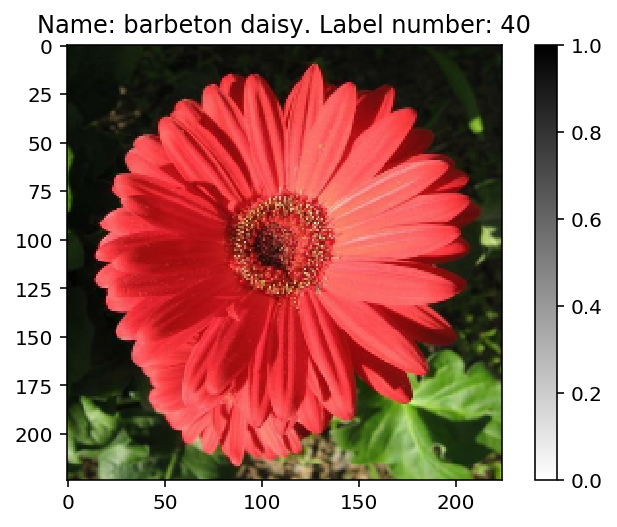

In [24]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

# Plot the image
plt.imshow(images[0], cmap = plt.cm.binary)
plt.colorbar()

plt.title('Name: '+class_names_new[str(labels[0])]+ '. Label number: '+str(labels[0]))
plt.show()

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [ ]:
# TODO: Build and train your network.

In [25]:
# Import pre-trained network
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

# Do not modify the weights from predefined nn
feature_extractor.trainable = False

In [26]:
type(feature_extractor)

tensorflow_hub.keras_layer.KerasLayer

## Documentation of models

**ToDo**
number of labels = `num_classes` = 102


**model_v1:**

    paramters:
    - Epochs = 50
    - l1 regularization
    - 2 hidden layers
        - h1: 500 units, dropout: 0.2
        - h2: 500 units, dropout: 0.2


In [27]:
# model v1
modelpara_EPOCHS = 100
modelpara_h1_numunits = 500
modelpara_h2_numunits = 500
modelpara_h1_dropout = 0.2
modelpara_h2_dropout = 0.2

In [28]:
def scheduler(epoch, lr):
    if epoch < modelpara_EPOCHS/2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [29]:
# Build model
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(modelpara_h1_numunits, activation = 'relu', kernel_regularizer='l1'),
        tf.keras.layers.Dropout(modelpara_h1_dropout),
        tf.keras.layers.Dense(modelpara_h2_numunits, activation = 'relu', kernel_regularizer='l1'),
        tf.keras.layers.Dropout(modelpara_h2_dropout),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Stop training when loss is invariant for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lrscheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Save the Model with the lowest validation loss
save_best = tf.keras.callbacks.ModelCheckpoint('./model_v1.h5',
                                               monitor='val_loss',
                                               save_best_only=True)
# plot model configuration
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 500)               640500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               51102     
Total params: 3,200,086
Trainable params: 942,102
Non-trainable params: 2,257,984
________________________________________

In [30]:
# save the untrained model
model.save('./model_v1_untrained.h5', overwrite=True)

In [31]:
# load the untrained model
model_untrained=tf.keras.models.load_model('./model_v1_untrained.h5', custom_objects={'KerasLayer':hub.KerasLayer})
#model_untrained = tf.keras.models.load_model('./model_v1_untrained.h5')

model_untrained.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 500)               640500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               51102     
Total params: 3,200,086
Trainable params: 942,102
Non-trainable params: 2,257,984
________________________________________

**Check GPU state**

In [32]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: False


In [34]:
# Run training iteration with GPU

#from workspace_utils import active_session

EPOCHS = 2 #modelpara_EPOCHS
#with active_session():
    # train the model
history = model.fit(train_batches,
                epochs = EPOCHS,
                validation_data=val_batches,
                callbacks=[early_stopping, save_best, lrscheduler])

Epoch 1/2
32/32 [==============================] - 96s 3s/step - loss: 180.2535 - accuracy: 0.0000e+00 - val_loss: 87.6526 - val_accuracy: 0.0000e+00
Epoch 2/2
32/32 [==============================] - 89s 3s/step - loss: 42.5262 - accuracy: 0.0000e+00 - val_loss: 15.3068 - val_accuracy: 0.0000e+00


In [ ]:
# TODO: Plot the loss and accuracy values achieved during training for the training set.
loss, accuracy = my_model.evaluate(test_batches)
print('\nLoss on the training set: {:,.3f}'.format(loss))
print('Accuracy on the training set: {:.3%}'.format(accuracy))

In [ ]:
# TODO: Plot the loss and accuracy values achieved during training for the validation set.
loss, accuracy = my_model.evaluate(val_batches)
print('\nLoss on the validation set: {:,.3f}'.format(loss))
print('Accuracy on the validation set: {:.3%}'.format(accuracy))

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# TODO: Print the loss and accuracy values achieved on the entire test set.



## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [35]:
# TODO: Save your trained model as a Keras model.

model.save('./model.h5', overwrite=True)

## Load the Keras Model

Load the Keras model you saved above.

In [36]:
# TODO: Load the Keras model

loaded_model = tf.keras.models.load_model('./model.h5', custom_objects={'KerasLayer':hub.KerasLayer})

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [ ]:
# TODO: Create the process_image function



To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

In [ ]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [ ]:
# TODO: Create the predict function



# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [ ]:
# TODO: Plot the input image along with the top 5 classes
